In [1]:
import argparse
import json
import logging
import os
import random
import time
import numpy as np
from sklearn import metrics

import torch
import torch.nn.functional as F

from imp import reload

In [2]:
from train_network import *

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rc('image', cmap='gray')

# Load model and parameters

In [4]:
# Experiments settings and snapshot
experiment_directory = './experiments/hcp_px160_k10_mp2/'
# experiment_directory = './experiments/hcp_pxfull_k10_mp2/'
continue_from = 'latest'

device = torch.device( 'cuda' ) if torch.cuda.is_available() else torch.device( 'cpu' )

Define model from *experiment_directory* settings and load saved state dictionary:

In [5]:
specs_filename = os.path.join(experiment_directory, "specs.json")

if not os.path.isfile(specs_filename):
    raise Exception(
        'The experiment directory does not include specifications file "specs.json"'
    )

specs = json.load(open(specs_filename))
arch = __import__("network", fromlist=["Decoder"])
latent_size = specs["CodeLength"]
decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])

# decoder = torch.nn.DataParallel(decoder)

saved_model_state = torch.load(
    os.path.join(
        experiment_directory, ws.model_params_subdir, continue_from + ".pth"
    )
)
saved_model_epoch = saved_model_state["epoch"]
decoder.load_state_dict(saved_model_state["model_state_dict"], strict=False)
decoder = decoder.to(device)

Create training data loader and load latent vectors:

In [6]:
code_bound = get_spec_with_default(specs, "CodeBound", None)


## Obtain the embeddings from a new experiment

# data_source = specs["DataSource"]
# scenes_per_batch = specs["ScenesPerBatch"]
# samples_per_scene = specs["SamplesPerScene"]

# num_data_loader_threads = get_spec_with_default(specs, "DataLoaderThreads", 1)

# loader = preprocessing.xyzs_loader(data_dir = data_source,
#                                    scenes_per_batch = scenes_per_batch,
#                                    samples_per_scene = samples_per_scene,
#                                    num_workers = num_data_loader_threads
#                                    )

# num_scenes = len(loader.data)

# lat_vecs = torch.nn.Embedding(num_scenes, latent_size, max_norm=code_bound).to(device)



## Or use the 1055 embeddings with Brain MRIs from HCP provided in github
lat_vecs = torch.nn.Embedding(1055, latent_size, max_norm=code_bound).to(device)



lat_epoch = load_latent_vectors(
            experiment_directory, continue_from + ".pth", lat_vecs
        )

### Generate samples from the model

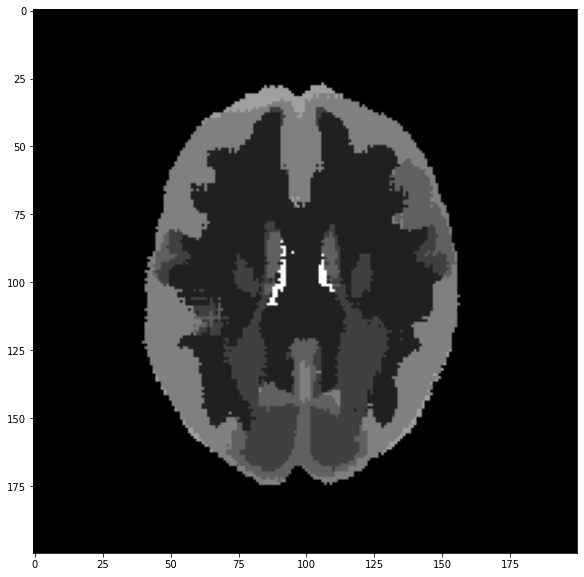

In [7]:
## Take a specific latent vector from training set [0,1055]

# i = torch.tensor([123]).to(device)
# features = lat_vecs(i)


## Or randomly sample from N(0,I)

features = torch.randn(specs["CodeLength"]).to(device) / 10



# Generate a grid with given resolution (central axial slide retreieve)
resolution = 200

y = torch.linspace(-1,1,resolution)
z = torch.linspace(-1,1,resolution)
grid_y, grid_z = torch.meshgrid(y,z)
grid_yz = torch.stack((grid_y,grid_z)).permute(1,2,0).reshape(-1,2)

# Append 0s to get central axial slide
grid_xyz = torch.cat((torch.zeros((grid_yz.shape[0],1)),grid_yz),dim=1)
grid_xyz = grid_xyz.to(device)

# Retrieve network outputs for the coordinate grid
decoder.eval()
with torch.no_grad():
    input = torch.cat([features.expand(grid_xyz.shape[0],-1), grid_xyz], dim=1)
    out = decoder(input)

# Get argmax to plot intensity clusters
out_argmax = out[:,:-1].argmax(1)
out_argmax = out_argmax.reshape(resolution,resolution)

# Plot
plt.imshow(out_argmax.cpu().numpy())

## Evaluation

For test dataset, obtain latent representations and calculate Anomaly Scores

In [8]:
#Define functions to retrieve z given image X using gradient descent and a function to get X given a z

def get_lat_vecs(img, samples,iterations, lat_vecs = None):
    ''' Retrieves optimal latent vector z for img, using backpropagation to move along latent space'''
    decoder.eval()
    XYZ = img.shape
    XYZ_t = torch.tensor(XYZ).unsqueeze(0).to(device)
    
    # If latent vectors are not passed, initialize randomly
    if lat_vecs is None:
        # initialize lat_vecs randomly and define loss fn and optimizer
        lat_vecs = torch.nn.Embedding(1, specs['CodeLength'], max_norm=specs['CodeBound']).to(device)
        torch.nn.init.normal_(
            lat_vecs.weight.data,
            0.0,
            get_spec_with_default(specs, "CodeInitStdDev", 1.0) / math.sqrt(latent_size),
            )

    # Define optimizer and loss
    optimizer_lat_vecs = torch.optim.Adam(lat_vecs.parameters(),)
    loss_fn_class = torch.nn.CrossEntropyLoss(reduction="sum")
    
    for i in range(iterations):
        
        # Sample K points, retrieve intensities for points sample and normalize coordinates
        xyz = [random.choices(range(size), k=samples) for size in XYZ]
        s = torch.from_numpy(img[tuple(xyz)]).to(device)

        xyz = torch.tensor(xyz).T.float().to(device)
        xyz /= XYZ_t
        xyz = (xyz * 2) - 1

        # Pass samples through network, calculate loss and apply backpropagation to latent vectors
        optimizer_lat_vecs.zero_grad()
        input = torch.cat([lat_vecs.weight.expand(xyz.shape[0],-1), xyz], dim=1)
        net_out = decoder(input)

        pred_logp_class = net_out

        batch_loss = loss_fn_class(pred_logp_class, s) / samples

        batch_loss.backward()
        optimizer_lat_vecs.step()
    
    return lat_vecs

def get_predictions(lat_vec, XYZ):
    '''Retrieves dense image with dimensionality XYZ from the model for lat_vec (z)'''
    x = torch.linspace(-1,1,XYZ[0])
    y = torch.linspace(-1,1,XYZ[1])
    z = torch.linspace(-1,1,XYZ[2])
    grid_x, grid_y, grid_z = torch.meshgrid(x,y,z)
    grid_xyz = torch.stack((grid_x,grid_y,grid_z)).permute(1,2,3,0).reshape(XYZ[0],-1,3)
    
    decoder.eval()
    recon_xyz = []
    
    for batch_xyz in grid_xyz:
        with torch.no_grad():
            input = torch.cat([lat_vec.weight.expand(batch_xyz.shape[0],-1), batch_xyz.to(device)], dim=1)
            out = decoder(input)
            recon_xyz.append(out.cpu())            

    recon_xyz = torch.stack(recon_xyz)
    recon_xyz = recon_xyz.reshape(XYZ+(-1,))
    
    return recon_xyz


Define test loader (retrieves the full volume and ground truth segmentation mask)

In [9]:
# Specify folder where evaluation / test folder sits
vol_loader = preprocessing.vol_loader('./data/BRATS_extracted/',
                                      samples=1,
                                      num_workers=1)

# Get a list of case ids to evaluate
list_evaluate = ['Brats18_2013_5_1','Brats18_CBICA_AOZ_1','Brats18_CBICA_ATP_1','Brats18_CBICA_AUR_1',
             'Brats18_TCIA02_309_1','Brats18_TCIA08_105_1','Brats18_TCIA09_141_1','Brats18_TCIA10_387_1']


Iterate through test set and get cross-entropy

In [10]:
segs = []
errors = []
cids = []

for i,img_batch in enumerate(vol_loader):
    
    if img_batch.cid[0] in list_evaluate:

        print(str(i)+" - "+img_batch.cid[0])
        start_time = time.time()
        img = img_batch.img[0].astype(int)
        seg = img_batch.seg[0]
        XYZ = img.shape
        
        # Get z and X'
        lat_vecs = get_lat_vecs(img,samples=10000,iterations=501)
        lat_vecs = get_lat_vecs(img,samples=50000,iterations=101, lat_vecs=lat_vecs)

        recon_xyz = get_predictions(lat_vecs, XYZ)
        
        # Calculate cross-entropy
        gt = torch.from_numpy(img).unsqueeze(0)
        xent = torch.nn.functional.cross_entropy(recon_xyz.unsqueeze(0).permute(0,4,1,2,3),gt,reduction='none')

        # Save cross-entropy, segmentations and case ids
        errors.append(xent)
        segs.append(seg)
        cids.append(img_batch.cid[0])

        print("--- %s seconds ---" % (time.time() - start_time))

# Concatenate lists
segs_all = torch.from_numpy(np.stack(segs))
segs_all = segs_all > 0
errors_all = torch.stack(errors)

54 - Brats18_CBICA_AUR_1
--- 34.03071331977844 seconds ---
66 - Brats18_TCIA08_105_1
--- 34.31215715408325 seconds ---
178 - Brats18_TCIA02_309_1
--- 34.40552639961243 seconds ---
191 - Brats18_CBICA_AOZ_1
--- 34.484283447265625 seconds ---
223 - Brats18_2013_5_1
--- 34.507631063461304 seconds ---
233 - Brats18_CBICA_ATP_1
--- 34.6333909034729 seconds ---
247 - Brats18_TCIA09_141_1
--- 34.71809673309326 seconds ---
251 - Brats18_TCIA10_387_1
--- 34.73126673698425 seconds ---


Post-processing of the anomaly score, consist of a MinPool layer [Implemented as -MaxPool(-X)] and an AvgPool layer

In [11]:
fs = 15
smooth_op = torch.nn.Sequential(torch.nn.MaxPool3d(kernel_size=3,stride=1,padding=1),
                                torch.nn.AvgPool3d(kernel_size=fs,stride=1,padding=fs//2),)

errors_smooth = []
for i in errors_all:
    i = i.unsqueeze(0).to(device)
    i_smooth = -smooth_op(-i).squeeze().cpu()
    errors_smooth.append(i_smooth)
    
errors_smooth = torch.stack(errors_smooth)


Get evaluation metrics for the Anomaly Scores. Note that DSC printed in the first cell is the max for all the curve, in test set it is needed to specify *thr* variable with the optimal threshold from the evaluation set

In [12]:
def scores(errors,segs,thr=None,dim=()):
    
    if thr is not None:
        f1 = 2 * torch.sum(segs * (errors>thr),dim=dim).to(torch.float32)\
            / (torch.sum(segs,dim=dim)+torch.sum(errors>thr,dim=dim))
        
        return f1, None
    else:
        prec,rec,thrs = metrics.precision_recall_curve(segs.numpy().reshape(-1),
                                       errors.numpy().reshape(-1),
                                       pos_label=1)
        

        f1 = 2 * prec * rec /(prec+rec)
        
        fpr, tpr, thresholds = metrics.roc_curve(segs.numpy().reshape(-1), errors.numpy().reshape(-1))
        auc = metrics.auc(fpr, tpr)
        
        ap = metrics.average_precision_score(segs.numpy().reshape(-1),errors.numpy().reshape(-1))
        
        return (f1, auc,fpr[tpr>.95].min(),ap), thrs[f1.argmax()]
    
(f1,auc,FPR95,ap),thr = scores(errors_smooth,segs_all)

print("ap: ",ap)
print("rocauc: ",auc)
print("FPR @95 Recall: ",FPR95)
print("DSC: ",np.nanmax(f1))
print("Threshold: ",thr)

ap:  0.7426597934312726
rocauc:  0.9928442442416932
FPR @95 Recall:  0.04257563615337583
DSC:  0.6948459755974447
Threshold:  1.3977065


In [13]:
val_thr = thr
f1, _ = scores(errors_smooth,segs_all,thr=val_thr,dim=(1,2,3))

print("DSC by case: ",f1)

print("DSC mean: ",f1.mean())
print("DSC std: ",f1.std())

DSC by case:  tensor([0.7572, 0.7156, 0.6673, 0.6942, 0.6954, 0.6461, 0.6524, 0.7087])
DSC mean:  tensor(0.6921)
DSC std:  tensor(0.0366)


### Qualitative analysis

In [14]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (30, 15)
matplotlib.rc('image', cmap='gray')

In [15]:
code_to_idx = {code:i for i,code in enumerate(list_evaluate)}
idxs = np.array([ code_to_idx[i] for i in list_evaluate])

Print original images:

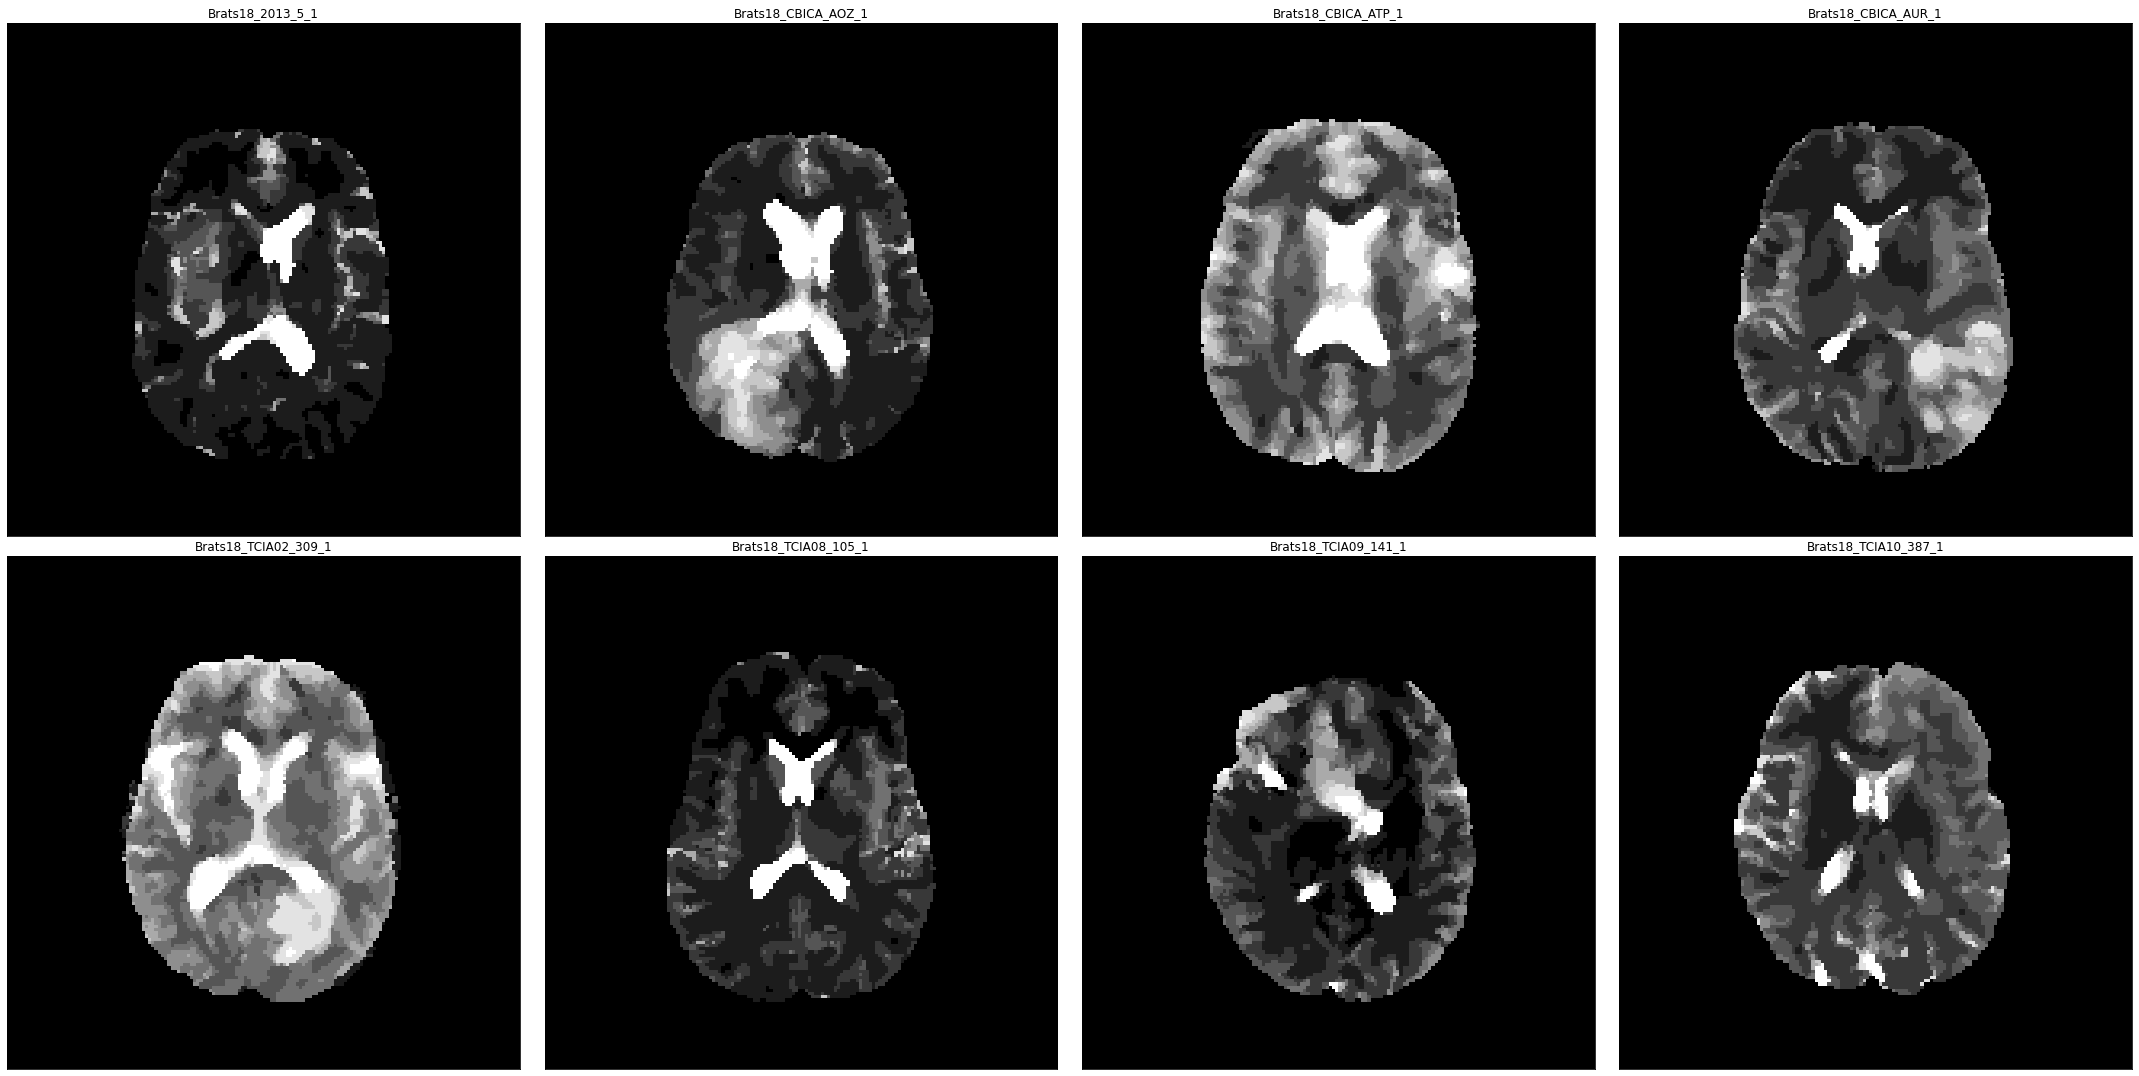

In [16]:
cols = 4
fig, ax = plt.subplots(2,cols)

for i,a in enumerate(ax):
    for j,b in enumerate(a):

        # Reload original image (pre-processed) 
        img = [img.img for img in vol_loader if img.cid[0] == cids[i*cols+j]][0]
        
        b.title.set_text(list_evaluate[i*cols+j])
        b.tick_params(axis='both',which='both',top=False,bottom=False,left=False,right=False, 
                      labelbottom=False, labelleft=False)
        
        b.imshow(img[0,80])
    
plt.tight_layout()

Print ground truth and segmentations:

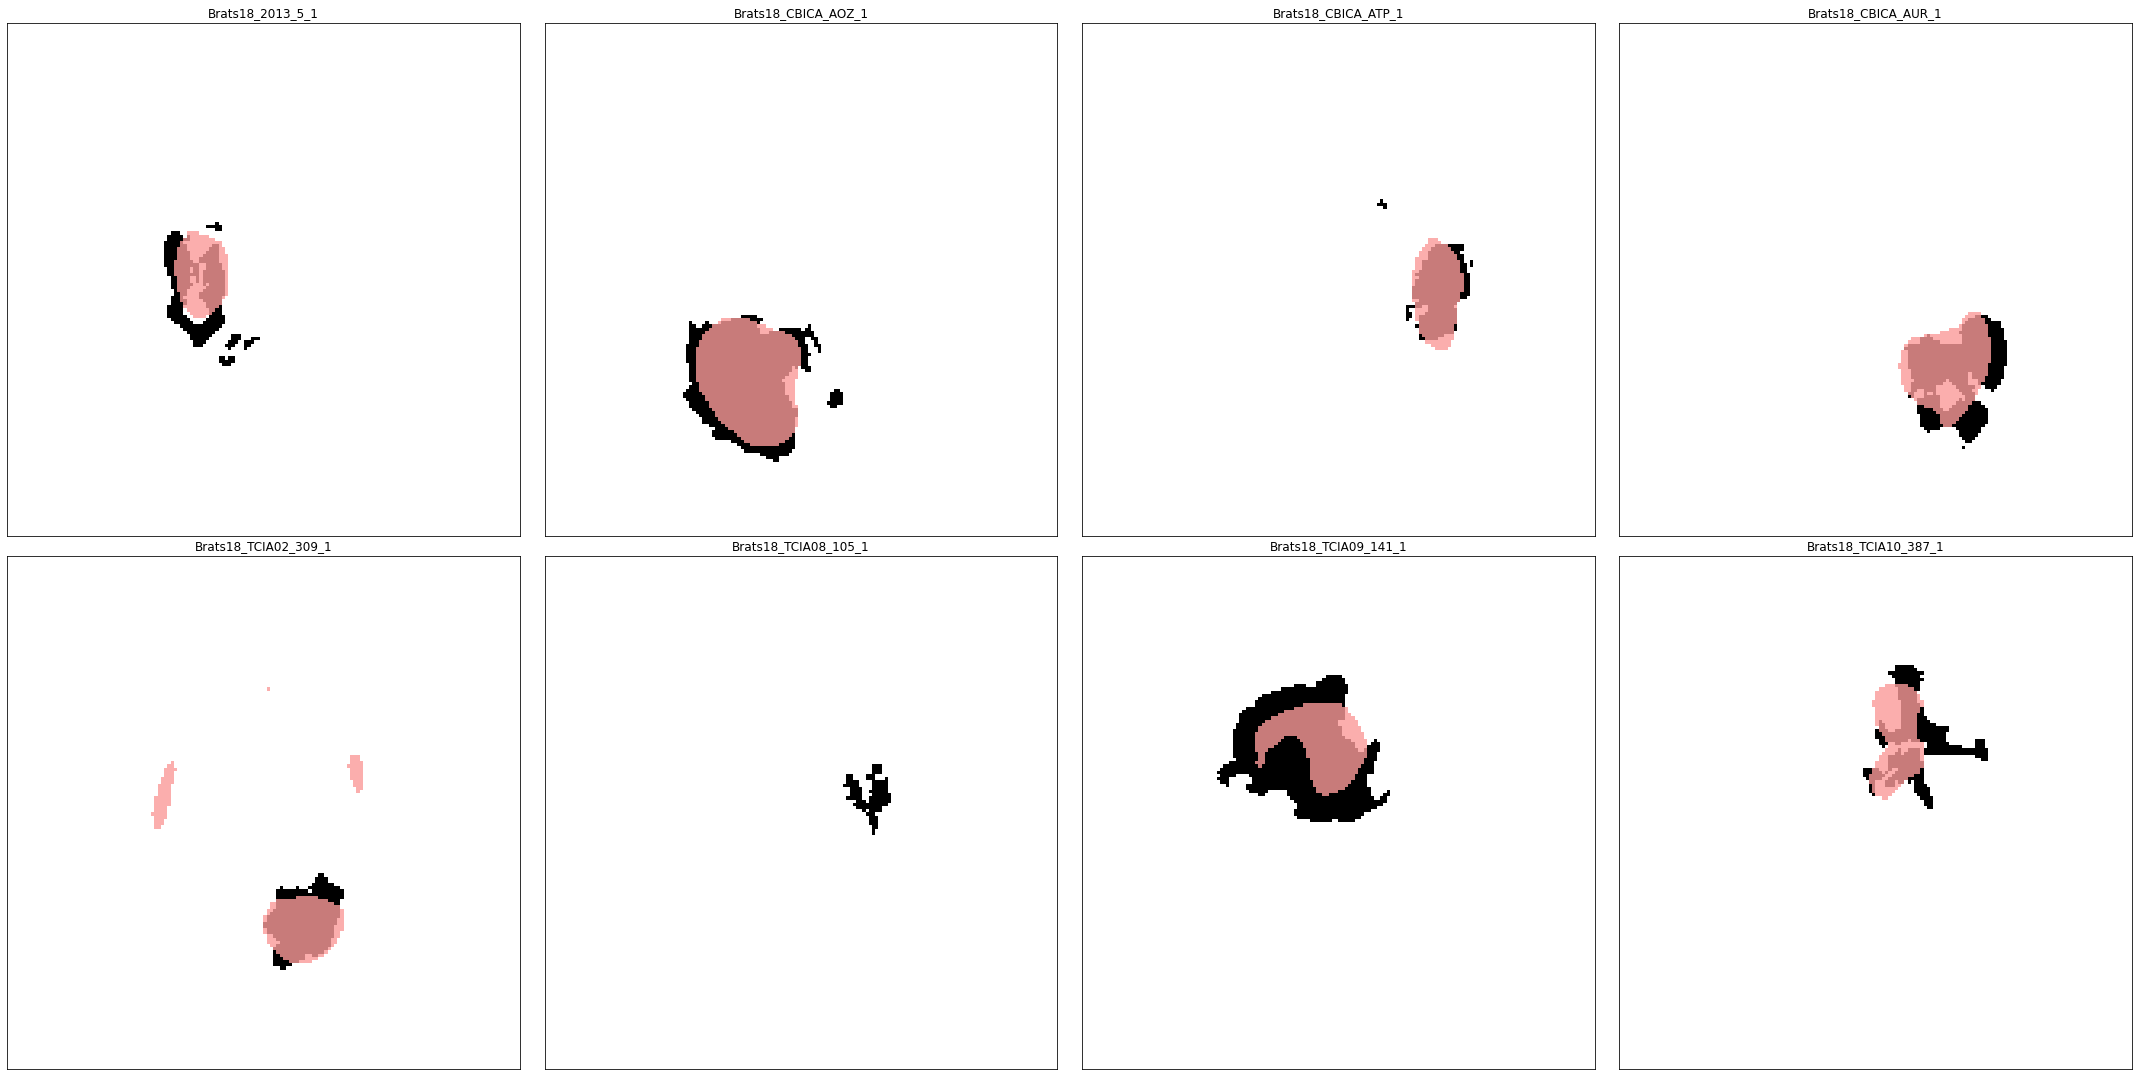

In [17]:
alpha = .8
cmap = plt.cm.get_cmap('Paired')
slice_no = 80

def merge_segmentations(anomaly_segmentation, ground_truth):
    
    img = (ground_truth == 0) * 1.
    
    c1 = torch.tensor(cmap(1)[:-1]).view(1,-1,1,1).float()
    c2 = torch.tensor(cmap(4)[:-1]).view(1,-1,1,1).float()    
    
    img = torch.where(anomaly_segmentation > 0, 
                      img * (1 - alpha) + alpha * c2,
                      img)

    return img.squeeze().permute(1,2,0)


cols = 4
fig, ax = plt.subplots(2,cols)

for i,a in enumerate(ax):
    for j,b in enumerate(a):
        viz = merge_segmentations(errors_smooth[idxs[i*cols+j],slice_no]>val_thr,
                                 segs_all[idxs[i*cols+j],slice_no])
        
        b.title.set_text(list_evaluate[i*cols+j])
        b.tick_params(axis='both',which='both',top=False,bottom=False,left=False,right=False, 
                      labelbottom=False, labelleft=False)
        
        b.imshow(viz)
    
plt.tight_layout()
